# Protein abundance change

This notebook runs the analyses on protein abundance changes between variant and reference alleles using Cell Painting assays

In [24]:
### imports
import os
import polars as pl
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from plot_utils import *
import sys
sys.path.append("../../../..")
from utils import *
%matplotlib inline

PLATEMAP_DIR = "../../../1_inputs/1_snakemake_pipeline/inputs/metadata/platemaps/{batch_id}/platemap"
PROF_DIR = "../../../3_outputs/1_snakemake_pipeline/2.sm_pipeline_outputs/batch_profiles"
CLASS_RES_DIR = "../../../3_outputs/1_snakemake_pipeline/2.sm_pipeline_outputs/classification_results"

## Disable truncation globally
# TRN_IMBAL_THRES = 3
# MIN_CLASS_NUM = 2
# pl.Config.set_tbl_rows(20)  # Show all rows
# pl.Config.set_tbl_cols(40)  # Show all columns

In [2]:
BIO_REP_BATCHES = ["2025_01_27_Batch_13", "2025_01_28_Batch_14"]
COMBINED_BIO_REP_DIR = "2025_01_Batch_13-14"

IMG_QC_DIR = f"../../../3_outputs/1_snakemake_pipeline/3.smp_results_analyses/1.image_qc_outputs/{COMBINED_BIO_REP_DIR}"
OUTPUT_DIR = f"../../../3_outputs/1_snakemake_pipeline/3.smp_results_analyses/2.cell_count_abundance_change/{COMBINED_BIO_REP_DIR}"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

## 1. Load Metadata

### 1.1 Meta allele data

In [4]:
batch_id = BIO_REP_BATCHES[0]
allele_meta_df = pl.DataFrame()

for platemap in os.listdir(PLATEMAP_DIR.format(batch_id=batch_id)):
    platemap_df = pl.read_csv(os.path.join(PLATEMAP_DIR.format(batch_id=batch_id), platemap), separator="\t", infer_schema_length=100000)
    allele_meta_df = pl.concat([allele_meta_df, platemap_df], how="diagonal_relaxed")

allele_meta_df.filter((pl.col("gene_allele").is_not_null())&(pl.col("node_type")=="allele")).unique(subset=["gene_allele"])
tested_variants = allele_meta_df.filter((pl.col("gene_allele").is_not_null())&(pl.col("node_type")=="allele")).unique(subset=["gene_allele"])["gene_allele"]

clin_var_annot_df = pl.read_csv("../../../../../1_allele_collection/3_outputs/varchamp_clinvar_gnomad.tsv", separator="\t", infer_schema_length=1000000)
allele_meta_df = allele_meta_df.join(
    clin_var_annot_df.with_columns(
        pl.concat_str([pl.col("symbol"), pl.col("aa_change")], separator="_").alias("gene_allele")
    ),
    on="gene_allele",
    how="left"
)
allele_meta_df

shape: (866, 510)
┌────────────┬────────────┬────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ plate_map_ ┆ well_posit ┆ symbol ┆ gene_alle ┆ … ┆ chr_pos_3 ┆ ref_right ┆ alt_right ┆ gnomad_af │
│ name       ┆ ion        ┆ ---    ┆ le        ┆   ┆ 8         ┆ ---       ┆ ---       ┆ ---       │
│ ---        ┆ ---        ┆ str    ┆ ---       ┆   ┆ ---       ┆ str       ┆ str       ┆ str       │
│ str        ┆ str        ┆        ┆ str       ┆   ┆ str       ┆           ┆           ┆           │
╞════════════╪════════════╪════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ B13A7A8P1_ ┆ A01        ┆ ABCD1  ┆ ABCD1     ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ R1         ┆            ┆        ┆           ┆   ┆           ┆           ┆           ┆           │
│ B13A7A8P1_ ┆ C01        ┆ ABCD1  ┆ ABCD1_Arg ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ R1         ┆            ┆        ┆ 518Trp    ┆   ┆           ┆           ┆           ┆           │
│ B13A7A8P1_ ┆ C01        ┆ ABCD1  ┆ ABCD1_Arg ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ R1         ┆            ┆        ┆ 518Trp    ┆   ┆           ┆           ┆           ┆           │
│ B13A7A8P1_ ┆ E01        ┆ ABCD1  ┆ ABCD1_Arg ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ R1         ┆            ┆        ┆ 389Gly    ┆   ┆           ┆           ┆           ┆           │
│ B13A7A8P1_ ┆ E01        ┆ ABCD1  ┆ ABCD1_Arg ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ R1         ┆            ┆        ┆ 389Gly    ┆   ┆           ┆           ┆           ┆           │
│ …          ┆ …          ┆ …      ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ B13A7A8P2_ ┆ L12        ┆ null   ┆ null      ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ R1         ┆            ┆        ┆           ┆   ┆           ┆           ┆           ┆           │
│ B13A7A8P2_ ┆ L14        ┆ MAPK9  ┆ MAPK9     ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ R1         ┆            ┆        ┆           ┆   ┆           ┆           ┆           ┆           │
│ B13A7A8P2_ ┆ J16        ┆ RHEB   ┆ RHEB      ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ R1         ┆            ┆        ┆           ┆   ┆           ┆           ┆           ┆           │
│ B13A7A8P2_ ┆ H18        ┆ SLIRP  ┆ SLIRP     ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ R1         ┆            ┆        ┆           ┆   ┆           ┆           ┆           ┆           │
│ B13A7A8P2_ ┆ F20        ┆ PRKACB ┆ PRKACB    ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ R1         ┆            ┆        ┆           ┆   ┆           ┆           ┆           ┆           │
└────────────┴────────────┴────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

### 1.2 Get the comparable REF-VAR pairs

The cell counts between Ref. and Var. alleles should be comparable (using a TRN_IMBAL_THRES = 3).

In [5]:
# Paths
# metrics_dir = "{}/{}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells"

# metrics_df, metrics_wtvar = pl.DataFrame(), pl.DataFrame()
# for batch in BIO_REP_BATCHES:
#     met_dir = metrics_dir.format(CLASS_RES_DIR, batch)
#     metrics_df_batch = pl.read_csv(f"{met_dir}/metrics.csv")
#     metrics_df = pl.concat([metrics_df, metrics_df_batch])
    # metrics_wtvar_batch = pl.read_csv(f"{met_dir}/metrics_summary.csv")
    # metrics_wtvar = pl.concat([metrics_wtvar, metrics_wtvar_batch])

## get individual classifiers pass the training imbalance threshold
# balanced_classifiers = metrics_df.filter(
#     (~pl.col("Metadata_Control"))
#     & (pl.col("Training_imbalance") < TRN_IMBAL_THRES)
#     & (
#         (pl.col("Full_Classifier_ID").str.contains("true")) ## protein_localization detection
#     )
# )

# balanced_class_alleles = balanced_classifiers.select(pl.col("allele_0","allele_1")).unique().to_numpy()
# balanced_class_alleles = np.unique(balanced_class_alleles.flatten())
# len(balanced_class_alleles)

## 2. CellProfiler Features

### Get the CP features for cells that passed the QC

In [6]:
pass_qc_prof_dir = "{}/{}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells.parquet"
cell_alleles = pl.DataFrame()

for batch_id in BIO_REP_BATCHES:
    # Get meta features
    batch_alleles = (
        pl.scan_parquet(
            pass_qc_prof_dir.format(PROF_DIR, batch_id)
        )
        # .filter(pl.col("Metadata_gene_allele").is_in(all_alleles))
        .with_columns(
            pl.concat_str(
                [
                    "Metadata_Plate",
                    "Metadata_Well",
                    "Metadata_ImageNumber",
                    "Metadata_ObjectNumber",
                ],
                separator="_",
            ).alias("Metadata_CellID")
        )
        .select([
            "Metadata_CellID",
            "Metadata_gene_allele",
            "Metadata_Well",
            "Metadata_Plate",
        ])
    )
    cell_alleles = pl.concat([cell_alleles, batch_alleles.collect()])

### Get the Cells_Intensity CP features per all cells

Merge the Cells_Intensity features to the pass-QC cells

In [7]:
combined_gfp_profiles = pl.DataFrame()
for batch_id in BIO_REP_BATCHES:
    # Get meta features
    batch_gfp_prof = (
        pl.scan_parquet(
            f"{PROF_DIR}/{batch_id}/profiles.parquet"
        ).with_columns(
            pl.concat_str(
                [
                    "Metadata_Plate",
                    "Metadata_Well",
                    "Metadata_ImageNumber",
                    "Metadata_ObjectNumber",
                ],
                separator="_",
            ).alias("Metadata_CellID")
        )
    )
    gfp_int = [i for i in batch_gfp_prof.collect_schema().names() if "Cells_Intensity" in i]
    gfp_int = ["Metadata_CellID"] + [i for i in gfp_int if "GFP" in i]

    combined_gfp_profiles = pl.concat([
        combined_gfp_profiles, 
        batch_gfp_prof.select(gfp_int).collect()
    ])

profiles = cell_alleles.join(combined_gfp_profiles, on="Metadata_CellID", how="left")

### Aggregate the cells to well profiles

In [8]:
well_profiles = (
    profiles.group_by(["Metadata_Plate", "Metadata_Well", "Metadata_gene_allele"])
    .agg(
        pl.col(col).median().alias(col)
        for col in profiles.columns
        if not col.startswith("Metadata_")
    )
    # .filter(pl.col("Metadata_gene_allele").is_in(balanced_class_alleles))
    .unique()
)

img_well_qc_sum = pl.read_csv(f"{IMG_QC_DIR}/plate-well-level_img_qc_sum.csv")
img_well_qc_sum_gfp = img_well_qc_sum.filter(pl.col("channel")=="GFP").with_columns(
    pl.col("plate").alias("Metadata_Plate"),
    pl.col("well").alias("Metadata_Well"),
)

well_profiles = well_profiles.join(
    img_well_qc_sum_gfp,
    on=["Metadata_Plate","Metadata_Well"],
    how="left"
)
print("Original image wells:", well_profiles.shape)

Original image wells: (5539, 72)


In [9]:
# def plot_gfp_per_plate(well_profile_df, gfp_feat="Cells_Intensity_IntegratedIntensity_GFP"):
#     plate_maps = set(["_".join(plate_map.split("_")[:-1]) for plate_map in sorted(well_profile_df["Metadata_Plate"].unique())])
#     for plate_map in plate_maps:
#         plate_map_cc = well_profile_df.filter(pl.col("Metadata_Plate").str.contains(plate_map))
#         plates = sorted(plate_map_cc["Metadata_Plate"].unique().to_list())
#         fig, axes = plt.subplots(2,2,figsize=(48,23)) ## sharey=True,sharex=True
#         for plate in plates:
#             plate_info = plate_map_cc.filter(pl.col("Metadata_Plate")==plate)
#             # display(plate_info.filter(pl.col("is_bg")))
#             # print(plates.index(plate))
#             plot_platemap(
#                 plate_info,
#                 plate,
#                 well_pos_col="Metadata_Well",
#                 # this is the column to color by (categorical or continuous)
#                 value_col=gfp_feat,
#                 # these columns will be concatenated into the annotation text
#                 label_cols=("Metadata_gene_allele",gfp_feat),
#                 ax=axes[plates.index(plate)//2, plates.index(plate)%2],
#                 value_type="continuous",   # or "continuous"
#                 continuous_cmap="vlag",  # matplotlib colormap for continuous mode
#                 grid_square=None
#             )
#         fig.subplots_adjust(wspace=-.55, hspace=.05)
#         plt.tight_layout()
#         plt.show()

# plot_gfp_per_plate(well_profiles)

In [10]:
well_profiles = well_profiles.filter(~pl.col("is_bg"))
print("Image wells after QC based on DAPI:", well_profiles.shape)

Image wells after QC based on DAPI: (5363, 72)


## 3. Calculate abundance hits

Use paired t-test to call abundance hits

In [35]:
from scipy.stats import shapiro
import re
from scipy.stats import wilcoxon
from scipy.stats import ttest_rel
import pandas as pd

GFP_FEAT = "Cells_Intensity_IntegratedIntensity_GFP" ##"Cells_Intensity_MeanIntensity_GFP"

# Convert letter rows to numbers
def well_to_coordinates(well):
    row_letter, col_number = re.match(r"([A-P])(\d{2})", well).groups()
    row_index = ord(row_letter) - ord('A') + 1  # Convert 'A'->1, 'B'->2, ..., 'P'->16
    col_index = int(col_number)  # Convert string column to integer
    return well, row_index, col_index


# Compute distances from edges and find the most centered well
def compute_distance(row, col):
    return min(row - 1, 16 - row, col - 1, 24 - col)  # Distance from nearest edge


## Abundance recalculation test: by Cell MeanIntensity
def paired_ttest(dat, reference: str, var: str, intensity_type: str=GFP_FEAT):
    # pivot to wide: one row per plate
    wide_gfp = dat.pivot(index="Metadata_Plate",
                         columns="Metadata_gene_allele",
                         values=intensity_type)
    # drop any plate that doesn’t have both measurements
    wide_gfp = wide_gfp.dropna(subset=[reference, var])
    if wide_gfp.shape[0] >= 3:
        # now run paired t-test
        t_stat, p_val = ttest_rel(wide_gfp[reference].astype(float), wide_gfp[var].astype(float))
    else:
        t_stat, p_val = None, None

    # ## perform stat test
    # dat = dat.dropna().sort_values(["Metadata_Plate","Metadata_gene_allele"])
    # # Assuming well_abun_stats is a DataFrame with columns 'reference_abundance' and 'variant_abundance'
    # reference_abundance = dat[dat["Metadata_gene_allele"]==reference][intensity_type].values
    # variant_abundance = dat[dat["Metadata_gene_allele"]==var][intensity_type].values
    # t_stat, p_val = ttest_rel(variant_abundance, reference_abundance)
    
    # Calculate Cohen's d
    mean_diff = np.mean(wide_gfp[var]) - np.mean(wide_gfp[reference])
    pooled_std = np.sqrt((np.std(wide_gfp[var], ddof=1) ** 2 + np.std(wide_gfp[reference], ddof=1) ** 2) / 2)
    cohen_d = mean_diff / pooled_std

    if (t_stat > 15 or t_stat < (-15)):
        print(wide_gfp)
        print(t_stat, p_val, cohen_d)
        print(list(wide_gfp[reference].astype(float)), list(wide_gfp[var].astype(float)))

    summary_df = pl.DataFrame(
        {
            "t_stat": t_stat,
            "p_val": p_val,
            "cohen_d": cohen_d
        }
    )
    summary_df = summary_df.with_columns(
        pl.lit(reference).alias("Gene"), pl.lit(var).alias("Variant")
    )
    return summary_df

In [36]:
well_abun_stats = []

for allele in tqdm(well_profiles.select(pl.col("Metadata_gene_allele")).to_pandas()["Metadata_gene_allele"].unique()):
    if allele is None or allele.split("_")[0] == allele or allele not in tested_variants:
        continue

    reference = allele.split("_")[0]
    temp_prof = well_profiles.filter(
        (pl.col("Metadata_gene_allele") == allele) | (pl.col("Metadata_gene_allele") == reference)
    ).select(
        pl.col(["Metadata_gene_allele","Metadata_Plate","Metadata_Well",GFP_FEAT,"median_plate"])
    ).to_pandas()

    ## subtract plate background
    # temp_prof[GFP_FEAT] = temp_prof[GFP_FEAT] - temp_prof["median_plate"]
    
    if (temp_prof["Metadata_gene_allele"].unique().shape[0] < 2):
        # print(temp_prof)
        continue

    var_profiles = temp_prof[temp_prof["Metadata_gene_allele"]==allele]
    ref_profiles = temp_prof[(temp_prof["Metadata_gene_allele"]==reference)&(temp_prof["Metadata_Plate"].isin(var_profiles["Metadata_Plate"].unique()))]
    temp_prof = pd.concat([var_profiles, ref_profiles])

    ref_wells = ref_profiles["Metadata_Well"].unique()
    var_wells = var_profiles["Metadata_Well"].unique()
    ref_var_pairs = [(ref_well, var_well) for ref_well in ref_wells for var_well in var_wells]
    # display(temp_prof)
    
    ## Per each ref-var well pair on the SAME plate, train and test the classifier
    for ref_var in ref_var_pairs:
        ## sort the wells to make sure they are from the same plate
        df_sampled = temp_prof[temp_prof["Metadata_Well"].isin(ref_var)].dropna().sort_values(["Metadata_Plate","Metadata_gene_allele"])
        # display(df_sampled)
        # break
        paired_t_res = paired_ttest(
            dat=df_sampled,
            reference=reference,
            var=allele
        ).with_columns(
            pl.lit(ref_var[0]).alias("Ref_well"),
            pl.lit(ref_var[1]).alias("Var_well")
        )
        well_abun_stats.append(
            paired_t_res
        )
    # break

# well_abun_stats = pl.concat(well_abun_stats, how="vertical")
# well_abun_stats = well_abun_stats.rename({"t_stat": "U2OS_t"})
# well_abun_stats = well_abun_stats.sort(["Gene", "Variant", "U2OS_t", "p_val", "cohen_d"])
# well_abun_stats

  6%|▌         | 38/613 [00:00<00:04, 132.25it/s]

Metadata_gene_allele          CCM2  CCM2_Gln313Arg
Metadata_Plate                                    
2025_01_27_B13A7A8P2_T1  66.498294      183.938294
2025_01_27_B13A7A8P2_T2  57.899381      212.159705
2025_01_27_B13A7A8P2_T3  56.503076      184.864497
2025_01_27_B13A7A8P2_T4  73.291309      214.869038
2025_01_28_B14A7A8P2_T1  42.449150      171.329620
2025_01_28_B14A7A8P2_T2  34.335066      191.909381
2025_01_28_B14A7A8P2_T3  40.417101      201.878835
2025_01_28_B14A7A8P2_T4  47.622129      181.362847
-24.896842384269426 4.3012104331854706e-08 9.668972921812731
[66.49829421879258, 57.89938126457855, 56.50307580345543, 73.29130916448776, 42.44915049930569, 34.33506641094573, 40.4171007303521, 47.62212948477827] [183.93829445145093, 212.1597051145509, 184.8644972315524, 214.86903760535645, 171.32962014427176, 191.90938083664517, 201.87883527111265, 181.36284697800875]
Metadata_gene_allele          CCM2  CCM2_Lys23Arg
Metadata_Plate                                   
2025_01_27_B13A7A8

 11%|█         | 65/613 [00:00<00:04, 125.84it/s]

Metadata_gene_allele             F9  F9_Cys28Arg
Metadata_Plate                                  
2025_01_27_B13A7A8P1_T1  161.685864    44.099211
2025_01_27_B13A7A8P1_T2  164.711205    48.351974
2025_01_27_B13A7A8P1_T3  166.868561    45.277769
2025_01_27_B13A7A8P1_T4  212.671023    45.016761
2025_01_28_B14A7A8P1_T1  135.008460    32.532966
2025_01_28_B14A7A8P1_T2  139.276529    34.202685
2025_01_28_B14A7A8P1_T3  163.925252    47.844894
2025_01_28_B14A7A8P1_T4  145.230154    49.022187
15.200294562595731 1.2837247491940444e-06 -6.643087653239909
[161.685864315019, 164.71120452310424, 166.86856068251655, 212.67102290550247, 135.00845998921432, 139.2765294907149, 163.92525157949422, 145.23015391023364] [44.09921074123122, 48.351973509881645, 45.277768682921305, 45.0167613006779, 32.532965975871775, 34.202684792515356, 47.844894498586655, 49.02218689030269]
Metadata_gene_allele           CCM2  CCM2_Asp431Asn
Metadata_Plate                                     
2025_01_27_B13A7A8P2_T1  118.3

 13%|█▎        | 79/613 [00:00<00:04, 126.24it/s]


TypeError: '>' not supported between instances of 'NoneType' and 'int'

## 3. Summarize Results

In [14]:
## drop the null alleles
well_abun_stats = well_abun_stats.drop_nulls(subset="U2OS_t")

## extract the alleles with only single appearance
variants_single = well_abun_stats.group_by("Variant").len().filter(pl.col("len")==1)["Variant"]
well_abun_stats_single = well_abun_stats.filter(pl.col("Variant").is_in(variants_single))

## extract the alleles with replicates
variants_replicate = well_abun_stats.group_by("Variant").len().filter(pl.col("len")>1).unique(subset="Variant")["Variant"]
well_abun_stats_rep = well_abun_stats.filter(pl.col("Variant").is_in(variants_replicate))

## check the consistency between replicates
well_abun_stats_rep_group = well_abun_stats_rep.group_by("Variant").agg(
    pl.len().alias("count"),
    (pl.col("U2OS_t")>0).sum().alias("desc"),
    (pl.col("U2OS_t")<0).sum().alias("incr")
)
inconsistent_alleles = well_abun_stats_rep_group.filter((pl.col("count")!=pl.col("desc"))&(pl.col("count")!=pl.col("incr")))["Variant"].unique()
display(well_abun_stats_rep_group.filter((pl.col("count")!=pl.col("desc"))&(pl.col("count")!=pl.col("incr"))))

## No problem them merge by mean
well_abun_stats_rep = well_abun_stats_rep.group_by(["Gene","Variant"]).agg(
    pl.col("U2OS_t").mean().alias("U2OS_t"),
    pl.col("p_val").mean().alias("p_val")
).with_columns(
    pl.when(pl.col("Variant").is_in(inconsistent_alleles))
    .then(pl.lit(1))
    .otherwise(pl.col("p_val"))
    .alias("manual_adj_pval")
)

shape: (97, 4)
┌─────────────────┬───────┬──────┬──────┐
│ Variant         ┆ count ┆ desc ┆ incr │
│ ---             ┆ ---   ┆ ---  ┆ ---  │
│ str             ┆ u32   ┆ u32  ┆ u32  │
╞═════════════════╪═══════╪══════╪══════╡
│ CCM2_Ser416Ala  ┆ 3     ┆ 1    ┆ 2    │
│ CCM2_Asn81Lys   ┆ 3     ┆ 2    ┆ 1    │
│ ZC4H2_Val63Leu  ┆ 2     ┆ 1    ┆ 1    │
│ CCM2_Ser245Cys  ┆ 3     ┆ 2    ┆ 1    │
│ BRIP1_Val76Ile  ┆ 3     ┆ 2    ┆ 1    │
│ …               ┆ …     ┆ …    ┆ …    │
│ CCM2_Thr241Ile  ┆ 3     ┆ 1    ┆ 2    │
│ BRIP1_Arg848His ┆ 3     ┆ 2    ┆ 1    │
│ CCM2_Ser60Arg   ┆ 3     ┆ 1    ┆ 2    │
│ CCM2_Ala232Val  ┆ 3     ┆ 2    ┆ 1    │
│ RAF1_Asp381Asn  ┆ 3     ┆ 1    ┆ 2    │
└─────────────────┴───────┴──────┴──────┘

In [15]:
well_abun_stats_final = pl.concat([
    well_abun_stats_rep,
    well_abun_stats_single.with_columns(
        pl.col("p_val").alias("manual_adj_pval")
    ).select(pl.col(well_abun_stats_rep.columns))
])

well_abun_stats_final = well_abun_stats_final.rename({"U2OS_t": "U2OS_paired_t_stat", "manual_adj_pval": "U2OS_paired_t_pval"})
well_abun_stats_final = well_abun_stats_final.select(["Gene", "Variant", "U2OS_paired_t_stat", "U2OS_paired_t_pval"]) ## , "U2OS_paired_tstat_edgedist_resid", "U2OS_t_edgedist_resid_pval",

In [16]:
# Total number of increase vs. decrease
total = well_abun_stats_final.shape[0]

## We are comparing REF - VAR in the paired_ttest ttest_rel
## The t-statistic is calculated as np.mean(a - b)/se, where se is the standard error.
## Thus, t-stat > 0 means REF more than VAR --> VAR decreasing CC
per_dec = well_abun_stats_final.filter(pl.col("U2OS_paired_t_stat") > 0).shape[0]
per_inc = well_abun_stats_final.filter(pl.col("U2OS_paired_t_stat") < 0).shape[0]

print("Total decreasin vs increasing percent:")
print(f"{per_dec} {per_dec / total * 100:.2f} %")
print(f"{per_inc} {per_inc / total * 100:.2f} %")

dec_sig = well_abun_stats_final.filter(pl.col("U2OS_paired_t_pval") < 0.05).filter(pl.col("U2OS_paired_t_stat") > 0).shape[0]
inc_sig = well_abun_stats_final.filter(pl.col("U2OS_paired_t_pval") < 0.05).filter(pl.col("U2OS_paired_t_stat") < 0).shape[0]

print("Number sig decreases")
print(dec_sig)
print("Number sig increases")
print(inc_sig)

Total decreasin vs increasing percent:
125 26.54 %
346 73.46 %
Number sig decreases
65
Number sig increases
205


In [17]:
well_abun_stats_final.sort(by="U2OS_paired_t_stat", descending=True)

shape: (471, 4)
┌────────┬──────────────────┬────────────────────┬────────────────────┐
│ Gene   ┆ Variant          ┆ U2OS_paired_t_stat ┆ U2OS_paired_t_pval │
│ ---    ┆ ---              ┆ ---                ┆ ---                │
│ str    ┆ str              ┆ f64                ┆ f64                │
╞════════╪══════════════════╪════════════════════╪════════════════════╡
│ RAD51D ┆ RAD51D_Glu233Gly ┆ 32.080535          ┆ 7.3948e-9          │
│ BRCA1  ┆ BRCA1_Glu455Lys  ┆ 21.198611          ┆ 1.3084e-7          │
│ RHO    ┆ RHO_Asp190Gly    ┆ 20.557453          ┆ 1.6173e-7          │
│ BRCA1  ┆ BRCA1_Thr616Ala  ┆ 20.426071          ┆ 1.6904e-7          │
│ RHO    ┆ RHO_Arg135Leu    ┆ 19.870958          ┆ 2.0441e-7          │
│ …      ┆ …                ┆ …                  ┆ …                  │
│ CCM2   ┆ CCM2_Ile372Leu   ┆ -21.376039         ┆ 0.000001           │
│ CCM2   ┆ CCM2_Gly188Trp   ┆ -22.033801         ┆ 0.000028           │
│ CCM2   ┆ CCM2_Asp442Asn   ┆ -22.40718          ┆ 0.000046           │
│ SOS2   ┆ SOS2_Val869Ile   ┆ -26.314751         ┆ 2.9295e-8          │
│ CCM2   ┆ CCM2_Gly379Ser   ┆ -31.914917         ┆ 1.0706e-7          │
└────────┴──────────────────┴────────────────────┴────────────────────┘

In [18]:
well_abun_stats_final.write_csv(f"{OUTPUT_DIR}/well-level_prot-abundance_changes.csv")

### 3.1 ClinVar analysis

In [22]:
well_abun_stats_final_clinvar = well_abun_stats_final.join(
    allele_meta_df.select(pl.col(["gene_allele","clinvar_clnsig_clean"])), 
    left_on="Variant",
    right_on="gene_allele",
    how="inner"
).drop_nulls(subset="clinvar_clnsig_clean")

<Figure size 640x480 with 0 Axes>

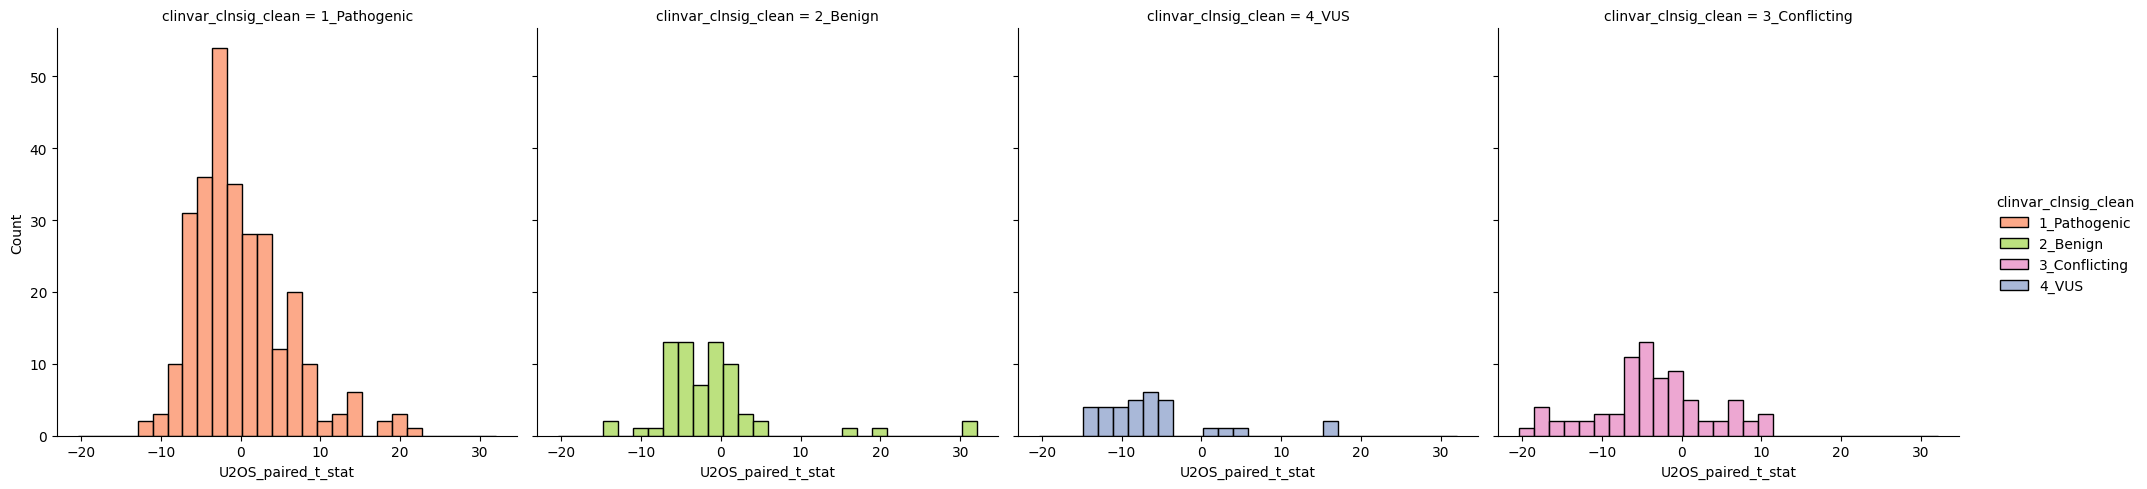

In [23]:
plt.clf()
sns.displot(
    data=well_abun_stats_final_clinvar.filter(pl.col("clinvar_clnsig_clean")!="5_Others").to_pandas(),
    x="U2OS_paired_t_stat",
    col="clinvar_clnsig_clean",
    hue="clinvar_clnsig_clean",
    palette=palette_dict["clinvar_clnsig_clean"],
    hue_order=['1_Pathogenic', '2_Benign', '3_Conflicting', '4_VUS']
)
plt.show()

## 4. Visualize Imaging Wells

In [25]:
TIFF_IMGS_DIR = "../../../2_analyses/1_snakemake_pipeline/2025_varchamp_snakemake/1.image_preprocess_qc/inputs/cpg_imgs"
OUT_IMGS_DIR = ""

In [26]:
img_well_qc_sum_gfp.filter(pl.col("well")=="F24")

shape: (8, 56)
┌──────────────┬──────┬─────────┬────────────┬───┬──────┬─────────────┬──────────────┬─────────────┐
│ plate        ┆ well ┆ channel ┆ mean       ┆ … ┆ c384 ┆ r384_letter ┆ Metadata_Pla ┆ Metadata_We │
│ ---          ┆ ---  ┆ ---     ┆ ---        ┆   ┆ ---  ┆ ---         ┆ te           ┆ ll          │
│ str          ┆ str  ┆ str     ┆ f64        ┆   ┆ i64  ┆ str         ┆ ---          ┆ ---         │
│              ┆      ┆         ┆            ┆   ┆      ┆             ┆ str          ┆ str         │
╞══════════════╪══════╪═════════╪════════════╪═══╪══════╪═════════════╪══════════════╪═════════════╡
│ 2025_01_27_B ┆ F24  ┆ GFP     ┆ 349.033741 ┆ … ┆ 24   ┆ F           ┆ 2025_01_27_B ┆ F24         │
│ 13A7A8P1_T1  ┆      ┆         ┆            ┆   ┆      ┆             ┆ 13A7A8P1_T1  ┆             │
│ 2025_01_27_B ┆ F24  ┆ GFP     ┆ 273.588489 ┆ … ┆ 24   ┆ F           ┆ 2025_01_27_B ┆ F24         │
│ 13A7A8P1_T2  ┆      ┆         ┆            ┆   ┆      ┆             ┆ 13A7A8P1_T2  ┆             │
│ 2025_01_27_B ┆ F24  ┆ GFP     ┆ 347.994006 ┆ … ┆ 24   ┆ F           ┆ 2025_01_27_B ┆ F24         │
│ 13A7A8P1_T3  ┆      ┆         ┆            ┆   ┆      ┆             ┆ 13A7A8P1_T3  ┆             │
│ 2025_01_27_B ┆ F24  ┆ GFP     ┆ 332.168671 ┆ … ┆ 24   ┆ F           ┆ 2025_01_27_B ┆ F24         │
│ 13A7A8P1_T4  ┆      ┆         ┆            ┆   ┆      ┆             ┆ 13A7A8P1_T4  ┆             │
│ 2025_01_28_B ┆ F24  ┆ GFP     ┆ 280.25712  ┆ … ┆ 24   ┆ F           ┆ 2025_01_28_B ┆ F24         │
│ 14A7A8P1_T1  ┆      ┆         ┆            ┆   ┆      ┆             ┆ 14A7A8P1_T1  ┆             │
│ 2025_01_28_B ┆ F24  ┆ GFP     ┆ 318.71265  ┆ … ┆ 24   ┆ F           ┆ 2025_01_28_B ┆ F24         │
│ 14A7A8P1_T2  ┆      ┆         ┆            ┆   ┆      ┆             ┆ 14A7A8P1_T2  ┆             │
│ 2025_01_28_B ┆ F24  ┆ GFP     ┆ 353.167254 ┆ … ┆ 24   ┆ F           ┆ 2025_01_28_B ┆ F24         │
│ 14A7A8P1_T3  ┆      ┆         ┆            ┆   ┆      ┆             ┆ 14A7A8P1_T3  ┆             │
│ 2025_01_28_B ┆ F24  ┆ GFP     ┆ 237.722878 ┆ … ┆ 24   ┆ F           ┆ 2025_01_28_B ┆ F24         │
│ 14A7A8P1_T4  ┆      ┆         ┆            ┆   ┆      ┆             ┆ 14A7A8P1_T4  ┆             │
└──────────────┴──────┴─────────┴────────────┴───┴──────┴─────────────┴──────────────┴─────────────┘

In [28]:
plot_allele(allele_meta_df.filter(pl.col("plate_map_name").str.contains("B13")), 
            "RHO_Arg135Leu", "GFP", plate_img_qc=img_well_qc_sum_gfp, site="05", max_intensity=0.99, display=True, imgs_dir=TIFF_IMGS_DIR)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

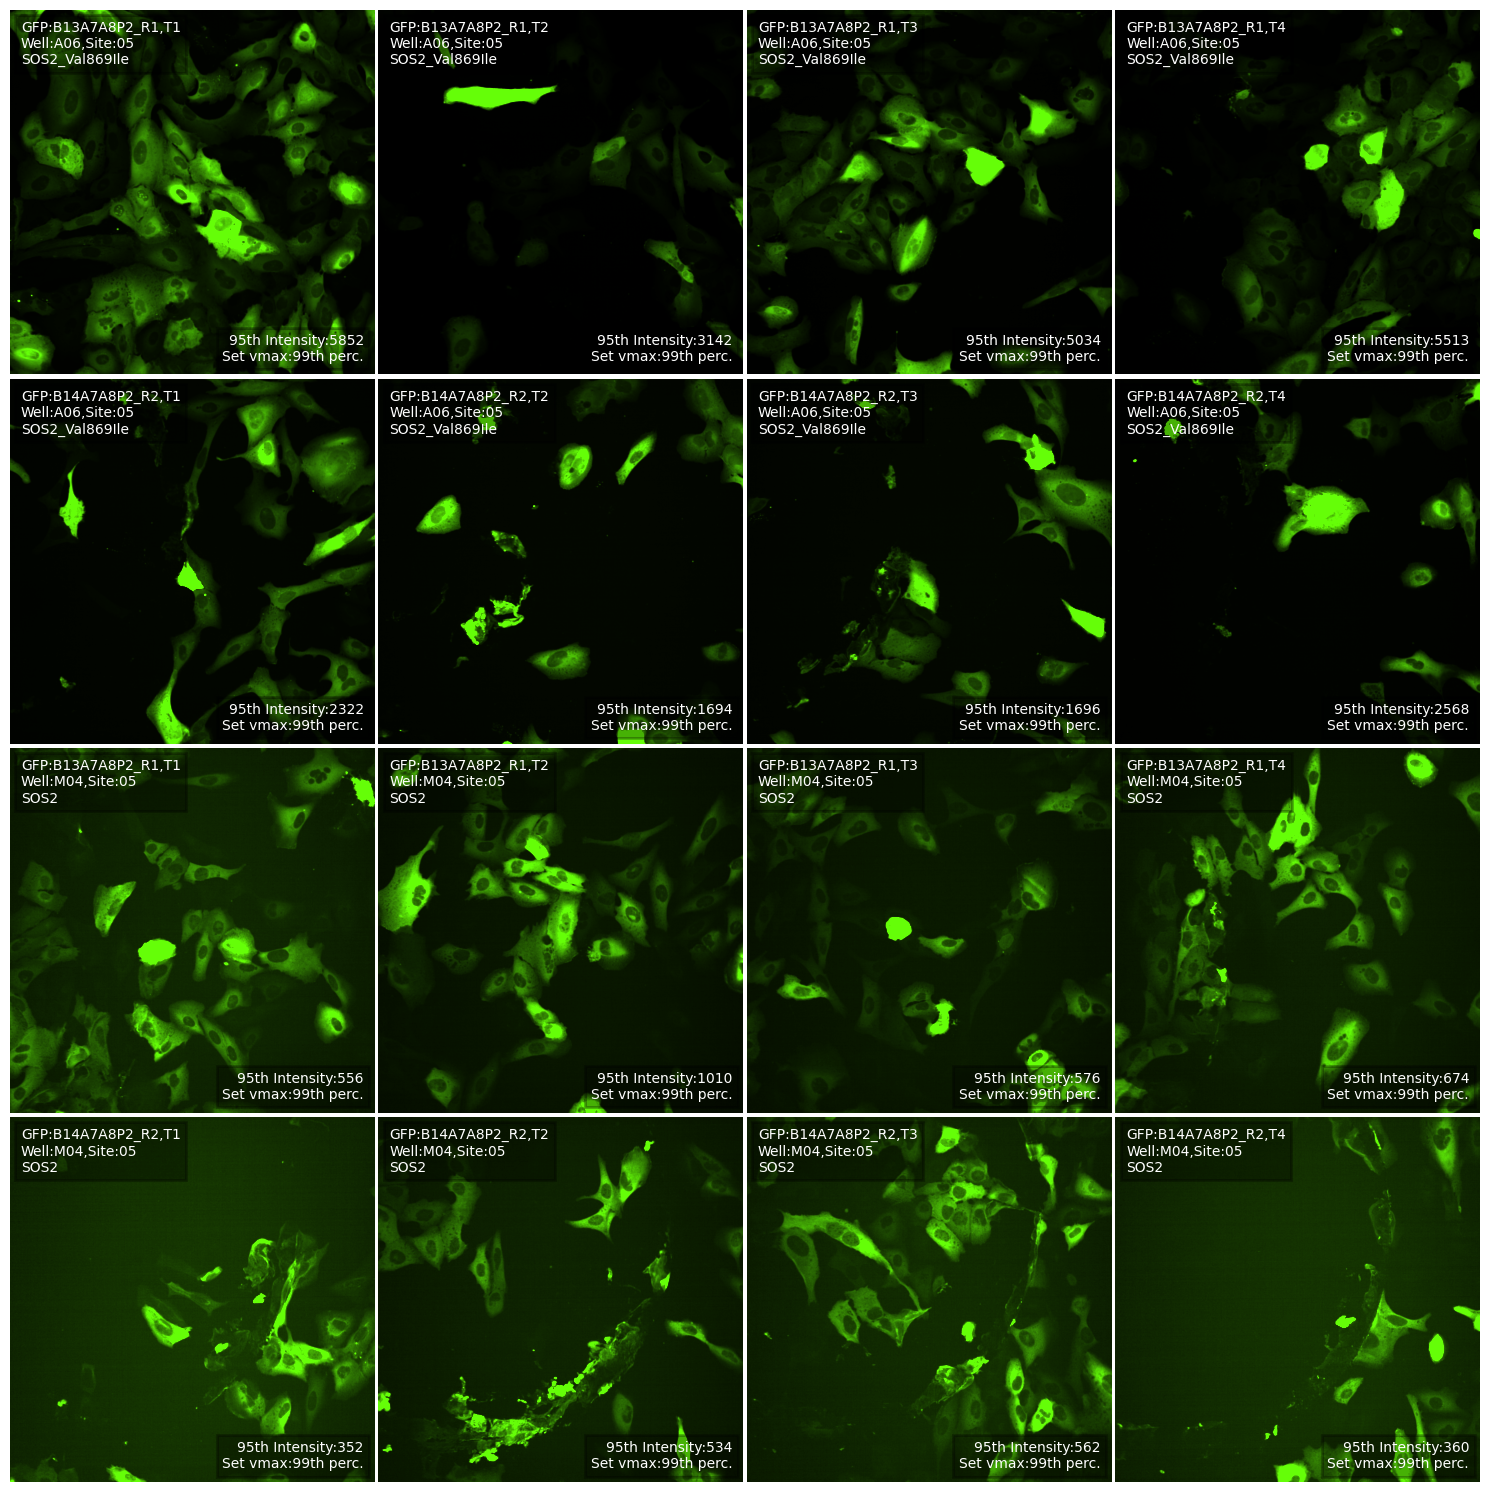

In [29]:
plot_allele(allele_meta_df.filter(pl.col("plate_map_name").str.contains("B13")), 
            "SOS2_Val869Ile", "GFP", plate_img_qc=img_well_qc_sum_gfp, site="05", max_intensity=0.99, display=True, imgs_dir=TIFF_IMGS_DIR)

In [87]:
allele_meta_df.filter(pl.col("gene_allele")=="RAD51D_Glu233Gly")
allele_meta_df.filter(pl.col("gene_allele")=="RAD51D")

shape: (2, 525)
┌────────────┬────────────┬────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ plate_map_ ┆ well_posit ┆ symbol ┆ gene_alle ┆ … ┆ clinvar_a ┆ RefSeq_mR ┆ StarStatu ┆ clinvar_c │
│ name       ┆ ion        ┆ ---    ┆ le        ┆   ┆ a_change_ ┆ NA_dbnsfp ┆ s_dbnsfp  ┆ lnsig_cle │
│ ---        ┆ ---        ┆ str    ┆ ---       ┆   ┆ dbnsfp    ┆ ---       ┆ ---       ┆ an_dbnsfp │
│ str        ┆ str        ┆        ┆ str       ┆   ┆ ---       ┆ str       ┆ i64       ┆ ---       │
│            ┆            ┆        ┆           ┆   ┆ str       ┆           ┆           ┆ str       │
╞════════════╪════════════╪════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ B13A7A8P1_ ┆ F24        ┆ RAD51D ┆ RAD51D    ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ R1         ┆            ┆        ┆           ┆   ┆           ┆           ┆           ┆           │
│ B13A7A8P2_ ┆ A01        ┆ RAD51D ┆ RAD51D    ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ R1         ┆            ┆        ┆           ┆   ┆           ┆           ┆           ┆           │
└────────────┴────────────┴────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

<Figure size 640x480 with 0 Axes>

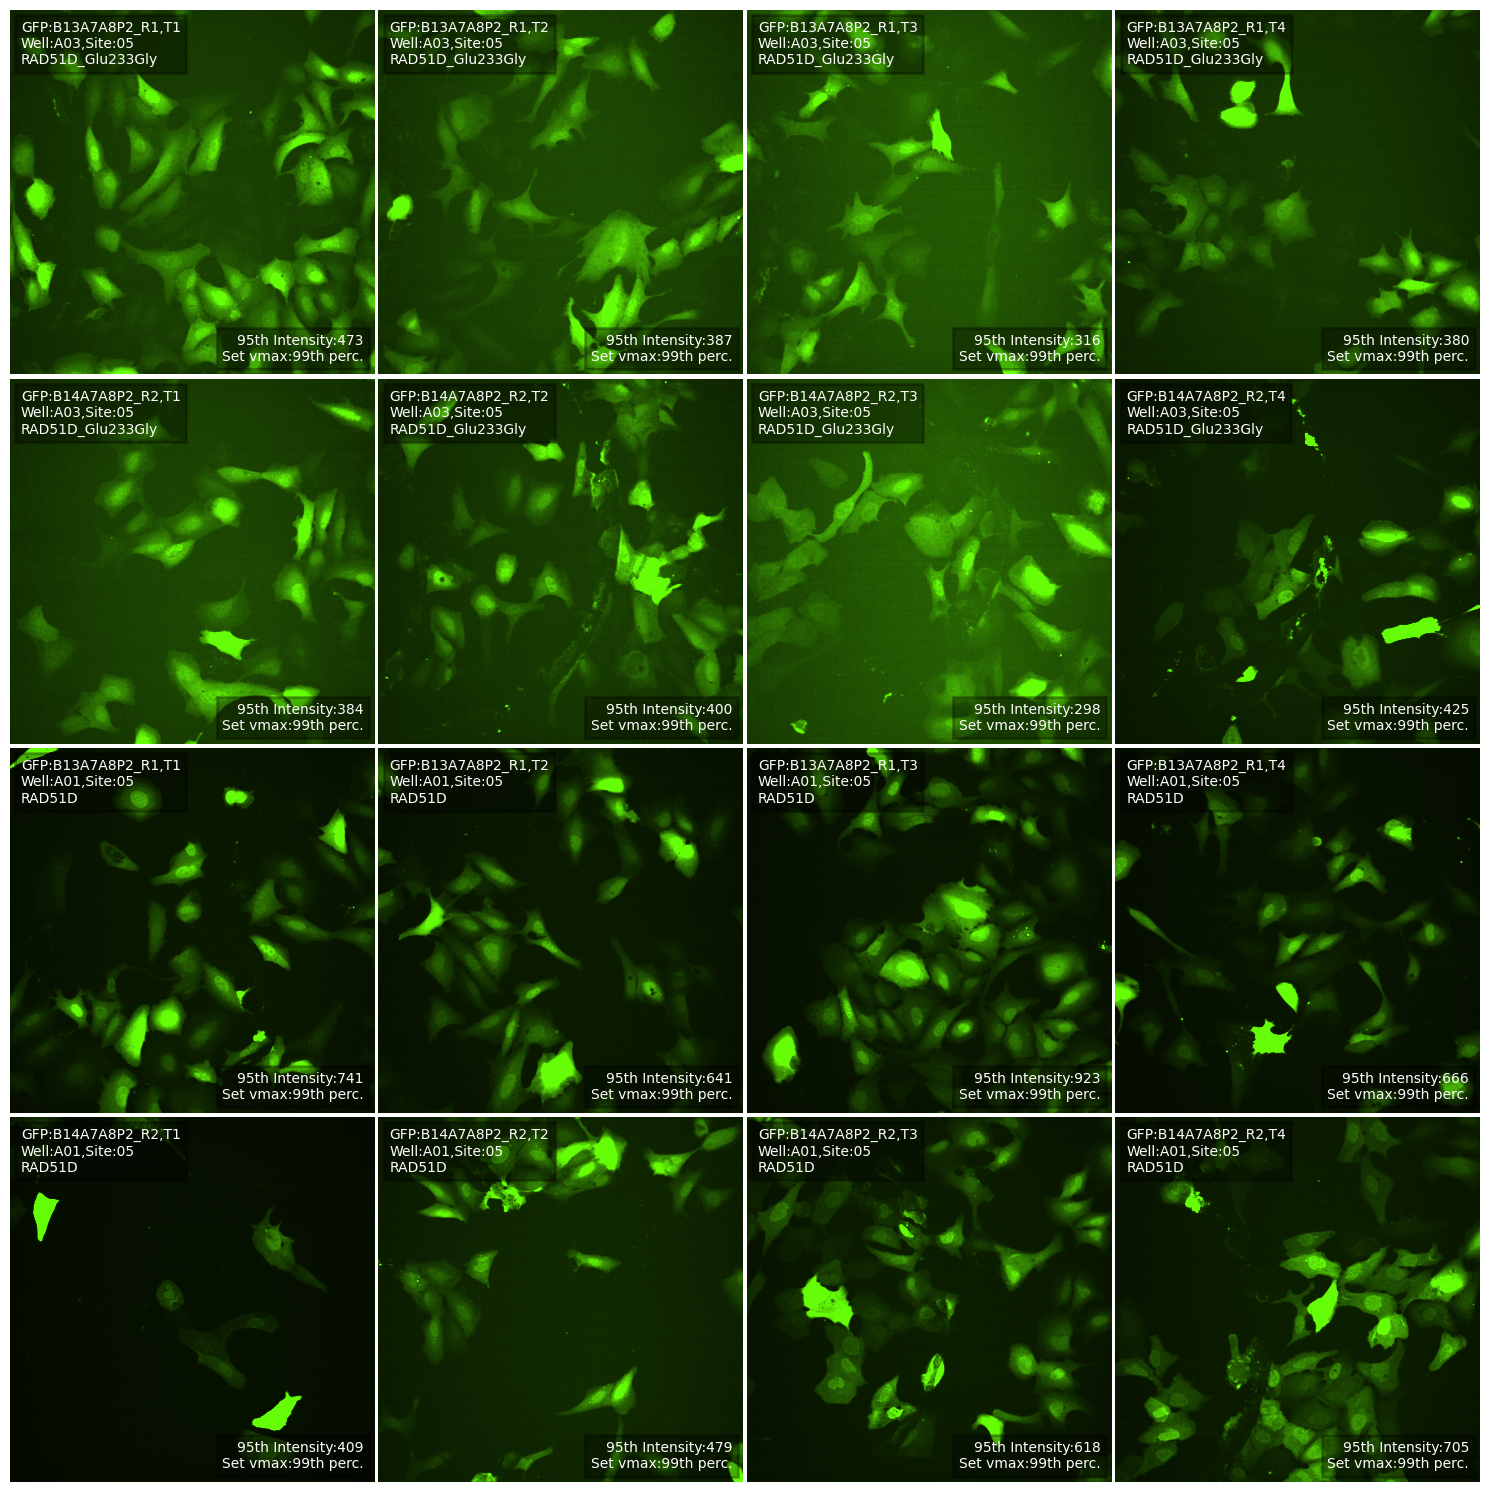

In [31]:
plot_allele(allele_meta_df.filter(pl.col("plate_map_name").str.contains("B13")), 
            "RAD51D_Glu233Gly", "GFP", ref_well=["A01"], plate_img_qc=img_well_qc_sum_gfp, site="05", max_intensity=0.99, display=True, imgs_dir=TIFF_IMGS_DIR)